In [1]:
import torch
import torch.nn as nn
from model import Multimodal
import time
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np

In [2]:
NUM_CLASSES     = 6                # HAP, SAD, ANG, FEA, DIS, NEU
EMOTION_MAP     = {"ANG":0, "DIS":1, "FEA":2, "HAP":3, "SAD":4, "NEU":5}
IMAGE_SIZE      = 224              # dùng cho ResNet/EfficientNet

# Audio
SAMPLE_RATE     = 16000            # chuẩn xử lý speech
N_FFT           = 1024             # ~64ms cửa sổ FFT
WIN_LENGTH      = 400              # 25ms window
HOP_LENGTH      = 160              # 10ms hop (frame shift)
N_MELS          = 128              # AST mặc định 128 mel bins
AUDIO_TIME_STEPS= 256              # ~5s audio @16kHz, pad/crop cho AST

# Train
BATCH_SIZE      = 16               # T4 chạy ổn với AST+ResNet18
EPOCHS          = 20               # converge nhanh, có thể early stop
LR              = 1e-4             # nhỏ hơn nếu fine-tune AST
WEIGHT_DECAY    = 1e-4
VAL_RATIO       = 0.18             # 82/18 train/val split
SEED            = 42

WAVE_SECONDS = 4.0  # độ dài tối đa mong muốn cho AST (10s chuẩn AST), có thể chỉnh 4.0-6.0 nếu clip ngắn
WAVE_TARGET_LEN = int(SAMPLE_RATE * WAVE_SECONDS)


# Scheduler
LR_SCHEDULER    = "step"           # giảm lr khi training
STEP_SIZE       = 10               # sau 10 epoch giảm lr
GAMMA           = 0.2              # lr *= gamma
SEQ_LEN = 3
CSV_PATH = '../dataset/cremad/cremad_paths.csv'
CSV_PATH_CROPPAD = '../dataset/cremad/cremad_paths_croppad.csv'
MODEL_SAVE_PATH = './checkpoints_partial'

In [3]:
n_folds = 1
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
criterion = nn.CrossEntropyLoss()
criterion.to(device)

CrossEntropyLoss()

In [5]:
# from data_process.audio_utils import preprocessing

# preprocessing(CSV_PATH)

In [6]:
import torchaudio

def load_wav(path: str, target_sr: int, mix_to_mono: bool = True):
    audio, sr = sf.read(path, dtype="float32", always_2d=False)

    if audio.ndim == 1:
        wav = torch.from_numpy(audio).unsqueeze(0)  # [1, T]
    else:
        wav = torch.from_numpy(audio).T             # [C, T]
        if mix_to_mono:
            wav = wav.mean(dim=0, keepdim=True)     # [1, T]

    if sr != target_sr:
        wav = torchaudio.functional.resample(wav, sr, target_sr)
        sr = target_sr

    return wav, sr

In [ ]:
import cv2
from torchaudio import transforms as T
from data_process.audio_utils import load_audio, get_mfccs
import config
import soundfile as sf
class EmotionDataset(Dataset):
    def __init__(self, df, is_train=True,  wave_seconds: float = WAVE_SECONDS):
        self.df = df
        self.is_train = is_train
        self.wave_target_len = int(SAMPLE_RATE * wave_seconds)

        # Image transformations
        self.image_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        # Audio transformations
        self.audio_transform = T.MelSpectrogram(
            sample_rate=config.SAMPLE_RATE,
            n_fft=config.N_FFT,
            hop_length=config.HOP_LENGTH,
            n_mels=config.N_MELS
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_frame_dir = '../dataset/'+row['video_frame_dir']
        audio_path = '../dataset/'+row['audio_path']
        emotion_label = EMOTION_MAP[row['emotion']]
        image = []
        for path in os.listdir(video_frame_dir):
            image_path = os.path.join(video_frame_dir, path)
            frame = cv2.imread(image_path)
            if frame is None:
                frame = np.zeros((IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.uint8)

            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = self.image_transform(frame)
            image.append(frame)
            if len(image) >= SEQ_LEN:
                break
        if len(image) < SEQ_LEN:
            for _ in range(SEQ_LEN - len(image)):
                image.append(image[-1])
        image = torch.stack(image, dim=0)

        waveform, sr = load_wav(audio_path, config.SAMPLE_RATE, mix_to_mono=True)

        if waveform.size(0) > 1:                            # mono
            waveform = waveform.mean(dim=0, keepdim=True)
        if sr != SAMPLE_RATE:                               # resample
            waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)
        maxv = waveform.abs().max().clamp_min(1e-8)
        waveform = (waveform / maxv).clamp(-1.0, 1.0)

        waveform = self._pad_or_truncate_waveform(waveform)  # (L_target,)

        return image, waveform, torch.tensor(emotion_label, dtype=torch.long)
    
    def _pad_or_truncate_waveform(self, wav: torch.Tensor) -> torch.Tensor:
        """
        wav: (1, L) mono
        - Train: random crop nếu dài
        - Eval : center crop
        - Pad 0 nếu ngắn
        Trả về (L_target,)
        """
        L = wav.size(-1)
        tgt = self.wave_target_len

        if L > tgt:
            if self.is_train:
                start = np.random.randint(0, L - tgt + 1)
            else:
                start = (L - tgt) // 2
            wav = wav[:, start:start + tgt]
        elif L < tgt:
            pad = tgt - L
            wav = torch.nn.functional.pad(wav, (0, pad), mode="constant", value=0.0)

        return wav.squeeze(0)  # (L,)

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv(CSV_PATH)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['emotion'])


In [9]:
train_dataset = EmotionDataset(train_df, is_train=True)
val_dataset = EmotionDataset(val_df, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [10]:
print(len(train_loader))
print(len(val_loader))

372
94


In [11]:
image, audio, label = train_dataset.__getitem__(0)
print("Audio shape:", audio.shape)
print("Image shape:", image.shape)
print("Label:", label)

Audio shape: torch.Size([64000])
Image shape: torch.Size([3, 3, 224, 224])
Label: tensor(5)


In [12]:
images, specs, labels = next(iter(train_loader))

print("Batch image shape:", images.shape)
print("Batch spectrogram shape:", specs.shape)
print("Batch labels:", labels)

Batch image shape: torch.Size([16, 3, 3, 224, 224])
Batch spectrogram shape: torch.Size([16, 64000])
Batch labels: tensor([4, 5, 3, 0, 3, 2, 0, 0, 0, 1, 2, 2, 1, 2, 1, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9629188..2.1833541].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9695679..2.2208865].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9695679..2.2208865].


Batch image shape: torch.Size([16, 3, 3, 224, 224])
Batch waveform shape: torch.Size([16, 64000])


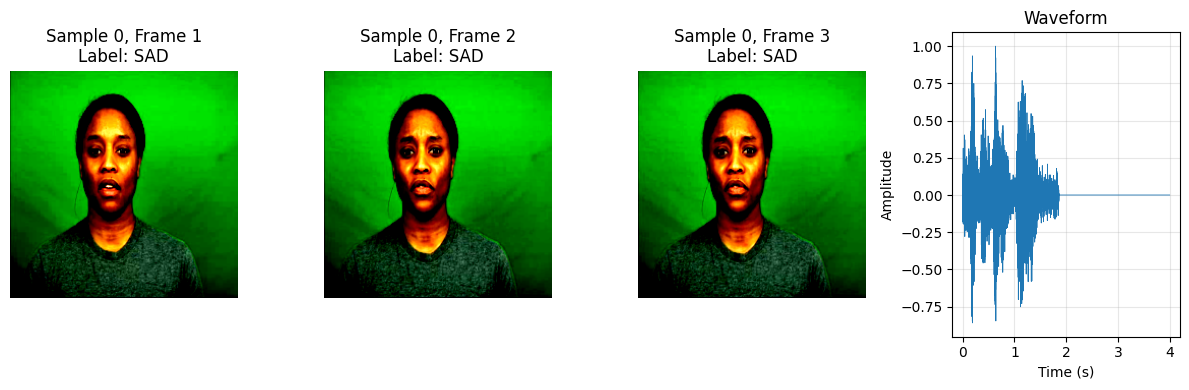

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7107626..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7453451..2.2489088].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6608418..2.2489088].


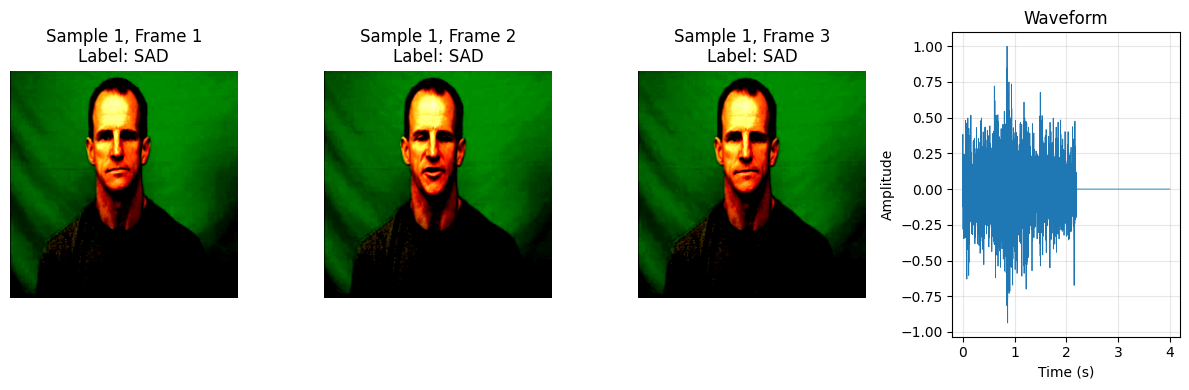

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8071774..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8038348..2.2486572].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8284318..2.2489088].


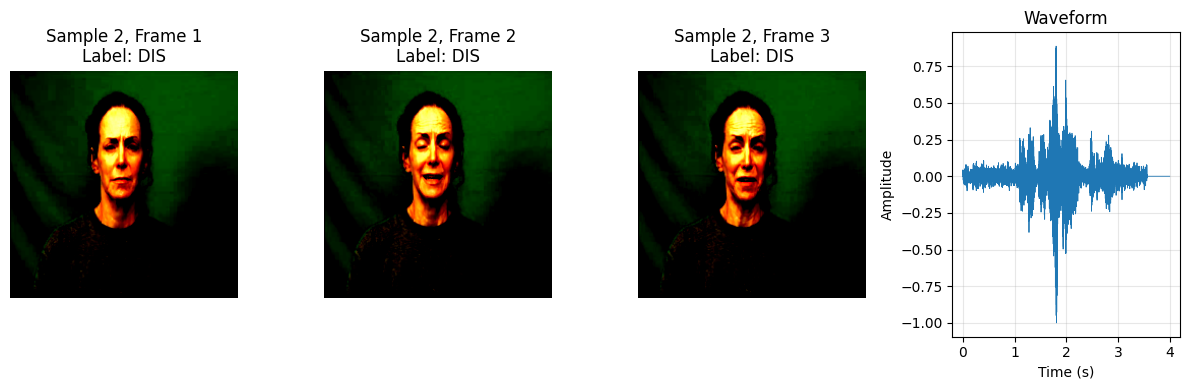

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9614705..0.92313796].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9813312..1.5545729].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9797995..1.1393019].


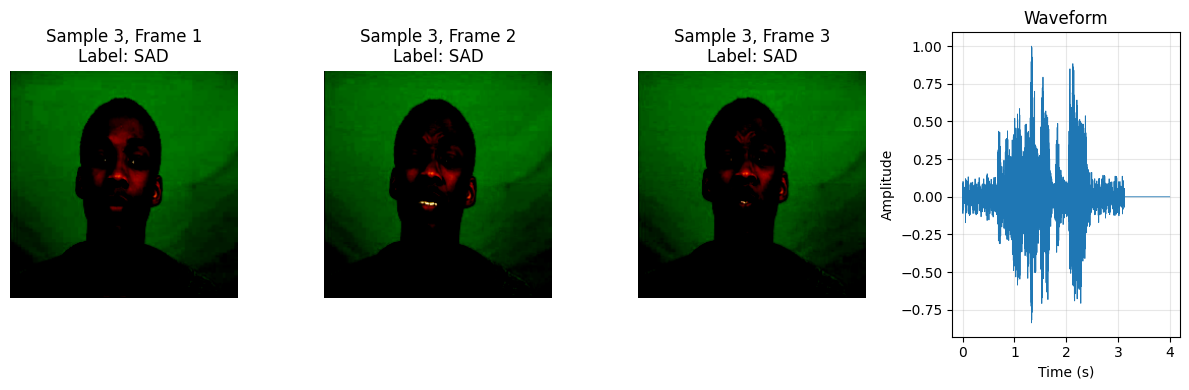

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6709969..2.2489088].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7029445..2.2489088].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7029445..2.2489088].


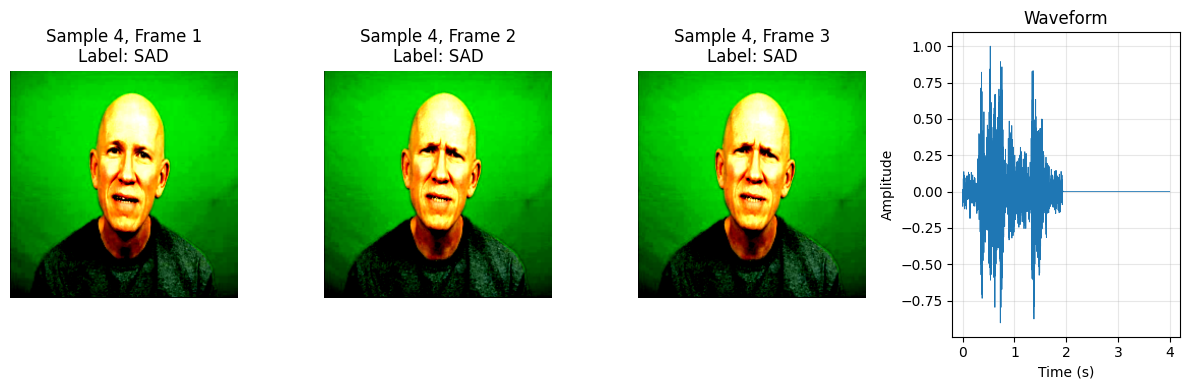

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6787702..1.8394805].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7169653..1.876597].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7889929..1.88095].


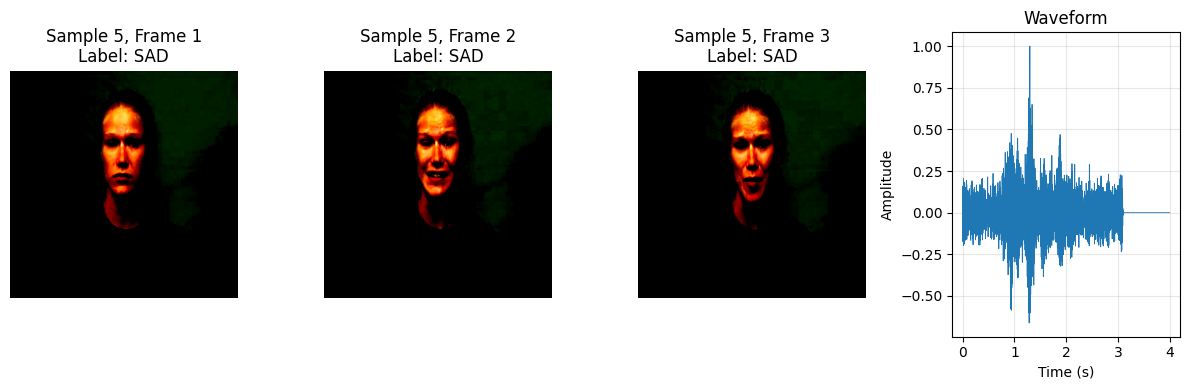

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7266923..2.248908].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8835725..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8835725..2.2489083].


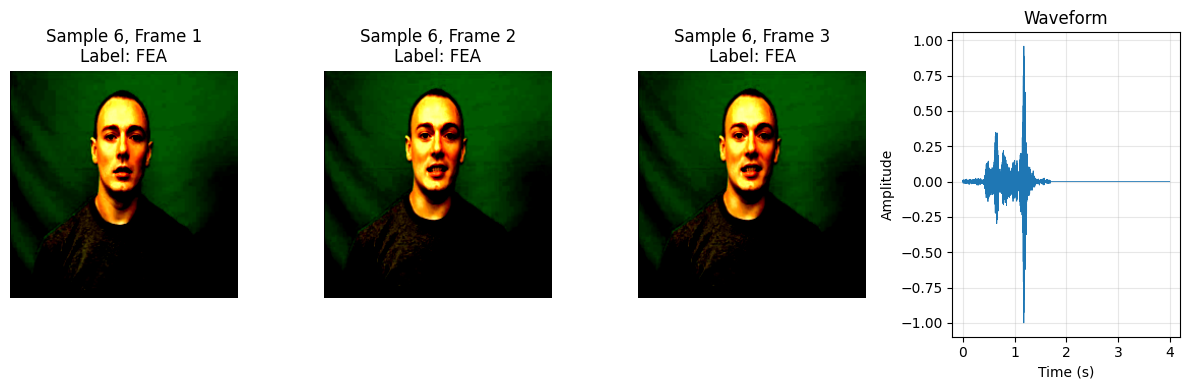

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6446738..2.2489088].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5787656..2.3008149].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6157644..2.2489088].


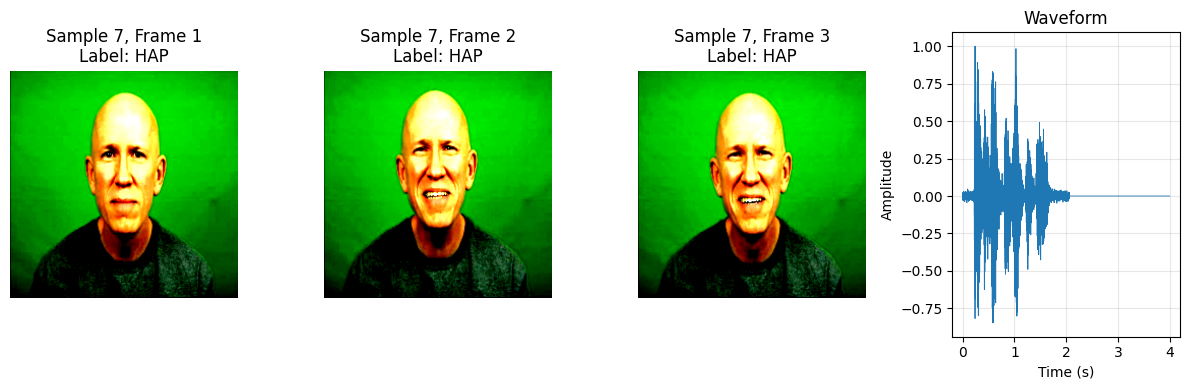

In [ ]:
import cv2
import matplotlib.pyplot as plt
images, waves, labels = next(iter(train_loader))

print("Batch image shape:", images.shape)   # (B, 3, 3, H, W)
print("Batch waveform shape:", waves.shape) # (B, L) or (B, 1, L)

batch_size = images.shape[0]
num_show = min(8, batch_size)
IDX2EMOTION = {v: k for k, v in EMOTION_MAP.items()}

def to_1d(w):
    return w.squeeze().cpu().numpy()

for i in range(num_show):
    frames = images[i]                  # (3, 3, H, W)
    wave   = to_1d(waves[i])            # (L,)
    label  = labels[i].item()
    label_name = IDX2EMOTION[label]

    t = np.arange(len(wave)) / SAMPLE_RATE

    plt.figure(figsize=(12, 4))

    for j in range(3):
        img = frames[j].permute(1, 2, 0).cpu().numpy()
        plt.subplot(1, 4, j + 1)
        plt.imshow(img)
        plt.title(f"Sample {i}, Frame {j+1}\nLabel: {label_name}")
        plt.axis("off")

    ax = plt.subplot(1, 4, 4)
    ax.plot(t, wave, linewidth=0.6)
    ax.set_title("Waveform")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


In [14]:
from transformers import AutoProcessor, ASTModel

model_id = "MIT/ast-finetuned-audioset-10-10-0.4593"
# processor = AutoProcessor.from_pretrained(model_id)
model = ASTModel.from_pretrained(model_id)

print(model.config.hidden_size)  # 768

c:\Users\Heathcliff\anaconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


768


In [15]:
# # --- Fusion modules placeholder ---

# import torchvision.models as tv
# class ConcatFusion(nn.Module):
#     def forward(self, a, v):
#         return torch.cat([a, v], dim=1)

# class GatingFusion(nn.Module):
#     def __init__(self, d_audio, d_img, d_out=256):
#         super().__init__()
#         self.proj_a = nn.Linear(d_audio, d_out)
#         self.proj_v = nn.Linear(d_img, d_out)
#         self.gate   = nn.Sigmoid()

#     def forward(self, a, v):
#         a_proj = self.proj_a(a)
#         v_proj = self.proj_v(v)
#         g = self.gate(a_proj + v_proj)
#         return g * a_proj + (1 - g) * v_proj

# class CrossAttentionFusion(nn.Module):
#     def __init__(self, d_audio, d_img, d_model=256, num_heads=4):
#         super().__init__()
#         self.a_proj = nn.Linear(d_audio, d_model)
#         self.v_proj = nn.Linear(d_img, d_model)
#         self.attn   = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
#         self.out    = nn.Linear(d_model, d_model)

#     def forward(self, a, v):
#         a = self.a_proj(a).unsqueeze(1)  # (B,1,D)
#         v = self.v_proj(v).unsqueeze(1)
#         out, _ = self.attn(a, v, v)
#         return self.out(out.squeeze(1))
    



# class MultimodalEmotionRecognizer(nn.Module):
#     """
#     img  : (B, T, 3, H, W)  # ví dụ T=3 frames
#     wave : (B, L) hoặc (B, 1, L) @16kHz
#     """
#     def __init__(self, num_classes=6, fusion="crossattn", image_backbone="resnet18",
#                  ast_model_id="MIT/ast-finetuned-audioset-10-10-0.4593", T=3):
#         super().__init__()
#         self.T = T

#         # ----- Image Encoder -----
#         if image_backbone == "resnet18":
#             img_backbone = tv.resnet18(weights=tv.ResNet18_Weights.IMAGENET1K_V1)
#             d_img = img_backbone.fc.in_features
#             img_backbone.fc = nn.Identity()
#             self.visual_net = img_backbone
#             self.conv1d = nn.Conv1d(in_channels=T, out_channels=1, kernel_size=1)
#         elif image_backbone == "efficientnet_b0":
#             self.visual_net = timm.create_model("efficientnet_b0", pretrained=True, num_classes=0)
#             d_img = self.visual_net.num_features
#         else:
#             raise ValueError("image_backbone must be 'resnet18' or 'efficientnet_b0'")

#         self.img_proj = nn.Linear(d_img, 128)
#         # d_img_proj = 128 * self.T  # concat theo thời gian
#         d_img_proj = 128  # sau conv1d

#         # ----- Audio Encoder (HF AST) -----
#         self.processor = AutoProcessor.from_pretrained(ast_model_id)
#         self.audio_net = ASTModel.from_pretrained(ast_model_id)
#         d_audio = self.audio_net.config.hidden_size  # ~768

#         # ----- Fusion -----
#         self.fusion_mode = fusion
#         if fusion == "concat":
#             d_fused = d_audio + d_img_proj
#             self.fusion = ConcatFusion()
#         elif fusion == "gating":
#             d_fused = 256
#             self.fusion = GatingFusion(d_audio, d_img_proj, d_out=d_fused)
#         elif fusion == "crossattn":
#             d_fused = 256
#             self.fusion = CrossAttentionFusion(d_audio, d_img_proj, d_model=d_fused, num_heads=4)
#         else:
#             raise ValueError(f"Unknown fusion type: {fusion}")

#         # ----- Classifier -----
#         self.classifier = nn.Sequential(
#             nn.Linear(d_fused, 128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, num_classes)
#         )

#     def _encode_images(self, imgs: torch.Tensor) -> torch.Tensor:
#         if imgs.dim() == 5:
#             B, T, C, H, W = imgs.shape
#             x = imgs.view(B*T, C, H, W)
#             feat = self.visual_net(x) # (B, 512) with resnet18
#             feat = self.img_proj(feat) # (B*T, 128)
#             #new conv1d
#             feat = feat.view(B, T, -1)  # (B, 128, T)
#             feat = self.conv1d(feat).squeeze(1)          # (B, 128)
#             # old shape is (B, 384)
#         elif imgs.dim() == 4:
#             feat = self.visual_net(imgs)
#             feat = self.img_proj(feat)
#         else:
#             raise ValueError(f"Unexpected image tensor shape: {imgs.shape}")
#         return feat

#     def _encode_audio_wave(self, wave: torch.Tensor) -> torch.Tensor:
#         if wave.dim() == 3:
#             wave = wave.squeeze(1)

#         wave_np = wave.detach().cpu().numpy().tolist()
#         with torch.no_grad():
#             inputs = self.processor(
#                 raw_speech=wave_np,
#                 sampling_rate=SAMPLE_RATE,
#                 return_tensors="pt",
#                 padding=True,
#             )
#         inputs = {k: v.to(wave.device) for k, v in inputs.items()}
#         outputs = self.audio_net(**inputs)
#         return outputs.last_hidden_state.mean(dim=1)

#     def forward(self, img: torch.Tensor, wave: torch.Tensor):
#         v = self._encode_images(img)
#         a = self._encode_audio_wave(wave)

#         fused  = self.fusion(a, v)
#         logits = self.classifier(fused)
#         return logits


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as tv
# nếu dùng timm / transformers:
# import timm
from transformers import AutoProcessor, ASTModel

SAMPLE_RATE = 16000

# ---------- Tiện ích ----------
class ModalityDropout(nn.Module):
    """
    Randomly drop one modality during training to improve robustness.
    p: xác suất drop mỗi modality độc lập (giới hạn sao cho không drop cả 2).
    """
    def __init__(self, p=0.15):
        super().__init__()
        self.p = p

    def forward(self, a, v):
        if not self.training:
            return a, v
        drop_a = torch.rand(1, device=a.device) < self.p
        drop_v = torch.rand(1, device=v.device) < self.p
        # tránh drop cả 2
        if drop_a and drop_v:
            drop_v = False
        if drop_a:
            a = torch.zeros_like(a)
        if drop_v:
            v = torch.zeros_like(v)
        return a, v

class ConcatFusion(nn.Module):
    def forward(self, a, v):
        return torch.cat([a, v], dim=1)

class GatingFusion(nn.Module):
    def __init__(self, d_audio, d_img, d_out=256):
        super().__init__()
        self.proj_a = nn.Linear(d_audio, d_out)
        self.proj_v = nn.Linear(d_img, d_out)
        self.ln_a   = nn.LayerNorm(d_out)
        self.ln_v   = nn.LayerNorm(d_out)
        self.gate   = nn.Sigmoid()

    def forward(self, a, v):
        a_proj = self.ln_a(self.proj_a(a))
        v_proj = self.ln_v(self.proj_v(v))
        g = self.gate(a_proj + v_proj)
        return g * a_proj + (1 - g) * v_proj

class CrossAttentionFusion(nn.Module):
    """
    Một chiều: a attends to v (A as query, V as KV), có residual + norm.
    Có thể mở rộng thành song phương nếu cần.
    """
    def __init__(self, d_audio, d_img, d_model=256, num_heads=4, p_drop=0.1):
        super().__init__()
        self.a_proj = nn.Linear(d_audio, d_model)
        self.v_proj = nn.Linear(d_img, d_model)
        self.attn   = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.out    = nn.Linear(d_model, d_model)
        self.ln_q   = nn.LayerNorm(d_model)
        self.ln_kv  = nn.LayerNorm(d_model)
        self.drop   = nn.Dropout(p_drop)

    def forward(self, a, v):
        q = self.ln_q(self.a_proj(a)).unsqueeze(1)  # (B,1,D)
        kv = self.ln_kv(self.v_proj(v)).unsqueeze(1)
        out, _ = self.attn(q, kv, kv)               # (B,1,D)
        out = q + self.drop(out)                    # residual
        out = self.out(out.squeeze(1))              # (B,D)
        return out

class TemporalPooling(nn.Module):
    """
    Thay thế conv1x1: dùng mean+max pooling theo T (ổn định, ít tham số).
    Input: (B, T, D) -> Output: (B, 2D) nếu concat mean+max; hoặc D nếu sum.
    """
    def __init__(self, mode="meanmax"):
        super().__init__()
        assert mode in ["mean", "max", "meanmax"]
        self.mode = mode

    def forward(self, x):  # x: (B, T, D)
        if self.mode == "mean":
            return x.mean(dim=1)                    # (B, D)
        elif self.mode == "max":
            return x.max(dim=1).values              # (B, D)
        else:  # meanmax
            m1 = x.mean(dim=1)
            m2 = x.max(dim=1).values
            return torch.cat([m1, m2], dim=1)      # (B, 2D)


class MultimodalEmotionRecognizer(nn.Module):
    """
    img  : (B, T, 3, H, W)  # ví dụ T=3 frames
    wave : (B, L) hoặc (B, 1, L) @16kHz
    """
    def __init__(
        self,
        num_classes=6,
        fusion="crossattn",
        image_backbone="resnet18",
        ast_model_id="MIT/ast-finetuned-audioset-10-10-0.4593",
        T=3,
        freeze_backbones=True,
        temporal_pool="meanmax"   # "mean" | "max" | "meanmax"
    ):
        super().__init__()
        self.T = T

        # ----- Image Encoder -----
        if image_backbone == "resnet18":
            img_backbone = tv.resnet18(weights=tv.ResNet18_Weights.IMAGENET1K_V1)
            d_img = img_backbone.fc.in_features
            img_backbone.fc = nn.Identity()
            self.visual_net = img_backbone
        # elif image_backbone == "efficientnet_b0":
        #     self.visual_net = timm.create_model("efficientnet_b0", pretrained=True, num_classes=0)
        #     d_img = self.visual_net.num_features
        else:
            raise ValueError("image_backbone must be 'resnet18'")  # rút gọn để rõ patch

        self.img_proj = nn.Linear(d_img, 128)
        self.img_norm = nn.LayerNorm(128)
        self.temporal_pool = TemporalPooling(mode=temporal_pool)
        d_img_proj = 128 if temporal_pool in ["mean", "max"] else 256

        # ----- Audio Encoder (HF AST) -----
        self.processor = AutoProcessor.from_pretrained(ast_model_id)
        self.audio_net = ASTModel.from_pretrained(ast_model_id)
        d_audio = self.audio_net.config.hidden_size  # ~768
        self.a_norm_in = nn.LayerNorm(d_audio)

        # ----- Fusion -----
        self.fusion_mode = fusion
        if fusion == "concat":
            d_fused = d_audio + d_img_proj
            self.fusion = ConcatFusion()
        elif fusion == "gating":
            d_fused = 256
            self.fusion = GatingFusion(d_audio, d_img_proj, d_out=d_fused)
        elif fusion == "crossattn":
            d_fused = 256
            self.fusion = CrossAttentionFusion(d_audio, d_img_proj, d_model=d_fused, num_heads=4)
        else:
            raise ValueError(f"Unknown fusion type: {fusion}")

        # ----- Modality dropout -----
        self.mod_drop = ModalityDropout(p=0.15)

        # ----- Classifier -----
        self.post_norm = nn.LayerNorm(d_fused)
        self.classifier = nn.Sequential(
            nn.Linear(d_fused, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        # ----- (Optional) Freeze backbones sớm để giảm overfit -----
        if freeze_backbones:
            for p in self.visual_net.parameters():
                p.requires_grad = False
            for p in self.audio_net.parameters():
                p.requires_grad = False

    def _encode_images(self, imgs: torch.Tensor) -> torch.Tensor:
        if imgs.dim() == 5:  # (B, T, 3, H, W)
            B, T, C, H, W = imgs.shape
            x = imgs.view(B*T, C, H, W)                 # (B*T,3,H,W)
            feat = self.visual_net(x)                   # (B*T, d_img)
            feat = self.img_proj(feat)                  # (B*T, 128)
            feat = self.img_norm(feat)
            feat = feat.view(B, T, 128)                 # (B, T, 128)
            # Temporal pooling (ổn định hơn conv1x1)
            feat = self.temporal_pool(feat)             # (B, d_img_proj)
        elif imgs.dim() == 4:  # (B, 3, H, W)
            feat = self.visual_net(imgs)
            feat = self.img_proj(feat)
            feat = self.img_norm(feat)
        else:
            raise ValueError(f"Unexpected image tensor shape: {imgs.shape}")
        return feat

    def _encode_audio_wave(self, wave: torch.Tensor) -> torch.Tensor:
        # wave: (B, L) hoặc (B, 1, L)
        if wave.dim() == 3:
            wave = wave.squeeze(1)  # (B, L)

        wave_np = wave.detach().cpu().numpy().tolist()
        with torch.no_grad():  # chỉ cho processor, không khoá gradient audio_net
            inputs = self.processor(
                raw_speech=wave_np,
                sampling_rate=SAMPLE_RATE,
                return_tensors="pt",
                padding=True,
            )
        inputs = {k: v.to(wave.device) for k, v in inputs.items()}
        outputs = self.audio_net(**inputs)              # giữ grad để fine-tune nếu không freeze
        a = outputs.last_hidden_state.mean(dim=1)       # (B, d_audio)
        a = self.a_norm_in(a)
        return a

    def forward(self, img: torch.Tensor, wave: torch.Tensor):
        v = self._encode_images(img)                    # (B, d_img_proj)
        a = self._encode_audio_wave(wave)               # (B, d_audio)

        # modality dropout (train-time only)
        a, v = self.mod_drop(a, v)

        fused = self.fusion(a, v)                       # (B, d_fused)
        fused = self.post_norm(fused)
        logits = self.classifier(fused)                 # (B, num_classes)
        return logits


In [17]:
# images = torch.randn(2, 3, 3, 224, 224).to(device)  # (B, T, 3, H, W)
# audio  = torch.randn(2, 16000 * 10).to(device)    # (B, L) ~10s @16kHz

# model  = MultimodalEmotionRecognizer(
#     num_classes=6,
#     fusion="crossattn",
#     image_backbone="resnet18",
#     ast_model_id="MIT/ast-finetuned-audioset-10-10-0.4593",
#     T=3
# ).to(device)
# model.forward(images, audio)

In [18]:
# # ---------- helpers ----------
# def _freeze(m: nn.Module):
#     for p in m.parameters():
#         p.requires_grad = False

# def _unfreeze(m: nn.Module):
#     for p in m.parameters():
#         p.requires_grad = True

# def _maybe_get(obj, path_list):
#     """Trả về thuộc tính đầu tiên tồn tại theo danh sách tên."""
#     for name in path_list:
#         if hasattr(obj, name):
#             return getattr(obj, name)
#     return None

# def _get_ast_block_list(ast_model: nn.Module):
#     """
#     Cố gắng lấy danh sách các encoder blocks của AST cho nhiều biến thể:
#     - HF ASTModel: .encoder.layer (ModuleList)
#     - timm (ViT-like): .blocks hoặc .backbone.blocks
#     Trả về (ModuleList|list|None)
#     """
#     # HuggingFace ASTModel
#     enc = _maybe_get(ast_model, ["encoder"])
#     if enc is not None:
#         layers = _maybe_get(enc, ["layer", "layers"])
#         if isinstance(layers, (list, nn.ModuleList)):
#             return layers

#     # timm ViT-like
#     blocks = _maybe_get(ast_model, ["blocks"])
#     if isinstance(blocks, (list, nn.ModuleList)):
#         return blocks

#     # một số timm gói backbone bên trong
#     backbone = _maybe_get(ast_model, ["backbone"])
#     if backbone is not None:
#         blocks = _maybe_get(backbone, ["blocks"])
#         if isinstance(blocks, (list, nn.ModuleList)):
#             return blocks

#     return None

# def _unfreeze_last_blocks(module_list, k: int):
#     """Unfreeze k blocks cuối nếu tồn tại."""
#     if module_list is None or k <= 0:
#         return
#     k = min(k, len(module_list))
#     for blk in module_list[-k:]:
#         _unfreeze(blk)

# def _set_module_eval(m: nn.Module):
#     # đặt eval cho cả cây con
#     for child in m.modules():
#         child.eval()

# def _freeze_and_eval(m: nn.Module):
#     for p in m.parameters():
#         p.requires_grad = False
#     _set_module_eval(m)  # tắt dropout + BN update

# # ---------- main finetune ----------
# def setup_finetune(model,
#                    img_unfreeze_last_blocks: int = 1,  # ResNet: 1 -> layer4; 2 -> layer3+4
#                    audio_unfreeze_last_blocks: int = 0  # HF/timm AST: số block encoder cuối mở
#                    ):
#     """
#     Freeze backbone (image + audio) và chỉ mở một phần cuối để finetune.
#     Luôn train: img_proj, fusion (nếu là nn.Module), classifier.
#     Hỗ trợ:
#       - Image: torchvision ResNet18, timm EfficientNet-B0
#       - Audio: HF ASTModel (encoder.layer[*]) hoặc timm AST (blocks)
#     """

#     # 1) Freeze toàn bộ backbone
#     # _freeze(model.visual_net)
#     # _freeze(model.audio_net)

#     _freeze_and_eval(model.visual_net)
#     _freeze_and_eval(model.audio_net)

#     # 2) Unfreeze image backbone cuối
#     # 2a) torchvision ResNet: layer1..layer4
#     if all(hasattr(model.visual_net, x) for x in ["layer1", "layer2", "layer3", "layer4"]):
#         layers_in_order = [
#             model.visual_net.layer1,
#             model.visual_net.layer2,
#             model.visual_net.layer3,
#             model.visual_net.layer4,
#         ]
#     if all(hasattr(model.visual_net, x) for x in ["layer4"]):
#         layers_in_order = [
#             model.visual_net.layer1,
#             model.visual_net.layer2,
#             model.visual_net.layer3,
#             model.visual_net.layer4,
#         ]
#         if img_unfreeze_last_blocks > 0:
#             for blk in layers_in_order[-img_unfreeze_last_blocks:]:
#                 _unfreeze(blk)

#         # cũng nên mở bn cuối/conv_head nếu có
#         # for name in ["bn1", "fc", "conv1"]:
#         #     if hasattr(model.visual_net, name):
#         #         _unfreeze(getattr(model.visual_net, name))

#         if img_unfreeze_last_blocks > 0:
#             for blk in layers_in_order[-img_unfreeze_last_blocks:]:
#                 _unfreeze(blk)

#     else:
#         # 2b) timm EfficientNet: mở vài block cuối nếu có .blocks, và head
#         timm_blocks = _maybe_get(model.visual_net, ["blocks", "stages"])
#         if isinstance(timm_blocks, (list, nn.ModuleList)) and img_unfreeze_last_blocks > 0:
#             _unfreeze_last_blocks(timm_blocks, img_unfreeze_last_blocks)
#         for name in ["conv_head", "bn2", "global_pool", "fc", "classifier"]:
#             if hasattr(model.visual_net, name):
#                 _unfreeze(getattr(model.visual_net, name))

#     # 3) Unfreeze audio backbone cuối (HF AST hoặc timm AST)
#     ast_blocks = _get_ast_block_list(model.audio_net)
#     _unfreeze_last_blocks(ast_blocks, audio_unfreeze_last_blocks)

#     # Với HF AST, thường nên mở thêm norm cuối
#     for name in ["layernorm", "ln_post", "norm"]:
#         if hasattr(model.audio_net, name):
#             _unfreeze(getattr(model.audio_net, name))

#     # 4) Luôn train các đầu nhẹ
#     _unfreeze(model.img_proj)
#     if isinstance(model.fusion, nn.Module):
#         _unfreeze(model.fusion)
#     _unfreeze(model.classifier)

#     # 5) In thống kê
#     trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
#     frozen    = sum(p.numel() for p in model.parameters() if not p.requires_grad)
#     print(f"[Finetune] Trainable: {trainable:,} | Frozen: {frozen:,}")

# def build_optimizer(model, lr_head=1e-3, lr_backbone=3e-4, weight_decay=1e-4):
#     head_params = list(model.img_proj.parameters()) + list(model.classifier.parameters())
#     if isinstance(model.fusion, nn.Module):
#         head_params += list(model.fusion.parameters())

#     img_ft_params = [p for p in model.visual_net.parameters() if p.requires_grad]
#     aud_ft_params = [p for p in model.audio_net.parameters()  if p.requires_grad]

#     param_groups = []
#     if head_params:
#         param_groups.append({"params": head_params, "lr": lr_head})
#     if img_ft_params:
#         param_groups.append({"params": img_ft_params, "lr": lr_backbone})
#     if aud_ft_params:
#         param_groups.append({"params": aud_ft_params, "lr": lr_backbone})

#     print(f"[Opt] head={sum(p.numel() for p in head_params):,} | "
#           f"img_ft={sum(p.numel() for p in img_ft_params):,} | "
#           f"aud_ft={sum(p.numel() for p in aud_ft_params):,}")

#     return torch.optim.AdamW(param_groups, weight_decay=weight_decay)


In [19]:
# ---------- helpers (patched) ----------
import torch
import torch.nn as nn

def _set_module_eval(m: nn.Module):
    """Đặt toàn bộ module (và con) về eval để tắt dropout & ngừng cập nhật BN stats."""
    # .eval() trên gốc là đủ, nhưng gọi theo modules() để chắc chắn các child cũng sync
    m.eval()
    for _ in m.modules():
        pass  # giữ chỗ; eval đã áp dụng trên gốc

def _freeze_and_eval(m: nn.Module):
    """Freeze tham số + chuyển module sang eval (ổn định khi backbone bị khoá)."""
    for p in m.parameters():
        p.requires_grad = False
    _set_module_eval(m)

def _unfreeze(m: nn.Module):
    for p in m.parameters():
        p.requires_grad = True

def _maybe_get(obj, path_list):
    """Trả về thuộc tính đầu tiên tồn tại theo danh sách tên."""
    for name in path_list:
        if hasattr(obj, name):
            return getattr(obj, name)
    return None

def _get_ast_block_list(ast_model: nn.Module):
    """
    Trả về danh sách các encoder blocks của AST cho nhiều biến thể:
    - HF ASTModel: .encoder.layer (ModuleList)
    - timm (ViT-like): .blocks hoặc .backbone.blocks
    """
    # HuggingFace ASTModel
    enc = _maybe_get(ast_model, ["encoder"])
    if enc is not None:
        layers = _maybe_get(enc, ["layer", "layers"])
        if isinstance(layers, (list, nn.ModuleList)):
            return layers

    # timm ViT-like
    blocks = _maybe_get(ast_model, ["blocks"])
    if isinstance(blocks, (list, nn.ModuleList)):
        return blocks

    # một số timm gói backbone bên trong
    backbone = _maybe_get(ast_model, ["backbone"])
    if backbone is not None:
        blocks = _maybe_get(backbone, ["blocks"])
        if isinstance(blocks, (list, nn.ModuleList)):
            return blocks

    return None

def _unfreeze_last_blocks(module_list, k: int):
    """Unfreeze k blocks cuối nếu tồn tại."""
    if module_list is None or k <= 0:
        return
    k = min(k, len(module_list))
    for blk in module_list[-k:]:
        _unfreeze(blk)

def setup_finetune(model,
                   img_unfreeze_last_blocks: int = 1,  # ResNet: 1 -> layer4; 2 -> layer3+4
                   audio_unfreeze_last_blocks: int = 0  # AST: số block encoder cuối mở
                   ):
    """
    Freeze backbone (image + audio) và chỉ mở một phần cuối để finetune.
    Luôn train: img_proj, fusion (nếu là nn.Module), classifier.
    Hỗ trợ:
      - Image: torchvision ResNet18, timm EfficientNet-B0 (chung ý tưởng)
      - Audio: HF ASTModel (encoder.layer[*]) hoặc timm AST (blocks)
    """

    # 1) Freeze toàn bộ backbone + eval (tắt dropout/BN update)
    _freeze_and_eval(model.visual_net)
    _freeze_and_eval(model.audio_net)

    # 2) Unfreeze image backbone cuối
    # 2a) torchvision ResNet: layer1..layer4
    if all(hasattr(model.visual_net, x) for x in ["layer1", "layer2", "layer3", "layer4"]):
        layers_in_order = [
            model.visual_net.layer1,
            model.visual_net.layer2,
            model.visual_net.layer3,
            model.visual_net.layer4,
        ]
        if img_unfreeze_last_blocks > 0:
            for blk in layers_in_order[-img_unfreeze_last_blocks:]:
                _unfreeze(blk)
        # KHÔNG tự động unfreeze conv1/bn1/fc để tránh tăng công suất sớm → dễ overfit
    else:
        # 2b) timm EfficientNet/...: mở vài block cuối nếu có .blocks/.stages, và head nếu cần
        timm_blocks = _maybe_get(model.visual_net, ["blocks", "stages"])
        if isinstance(timm_blocks, (list, nn.ModuleList)) and img_unfreeze_last_blocks > 0:
            _unfreeze_last_blocks(timm_blocks, img_unfreeze_last_blocks)
        # Nếu có head chuyên biệt, có thể unfreeze về sau khi cần:
        # for name in ["conv_head", "bn2", "global_pool", "fc", "classifier"]:
        #     if hasattr(model.visual_net, name):
        #         _unfreeze(getattr(model.visual_net, name))

    # 3) Unfreeze audio backbone cuối (HF AST hoặc timm AST)
    ast_blocks = _get_ast_block_list(model.audio_net)
    _unfreeze_last_blocks(ast_blocks, audio_unfreeze_last_blocks)

    # Với HF AST, thường nên mở thêm norm cuối (nếu có)
    for name in ["layernorm", "ln_post", "norm"]:
        if hasattr(model.audio_net, name):
            _unfreeze(getattr(model.audio_net, name))

    # 4) Luôn train các đầu nhẹ
    _unfreeze(model.img_proj)
    if isinstance(model.fusion, nn.Module):
        _unfreeze(model.fusion)
    _unfreeze(model.classifier)

    # 5) In thống kê
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen    = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    print(f"[Finetune] Trainable: {trainable:,} | Frozen: {frozen:,}")

# ---------- optimizer (patched) ----------
def _split_decay_no_decay(named_params):
    """Tách params thành (decay, no_decay) theo tên, loại trừ norm/bias khỏi weight decay."""
    decay, no_decay = [], []
    for name, p in named_params:
        if not p.requires_grad:
            continue
        lname = name.lower()
        if lname.endswith(".bias") or ("norm" in lname) or ("bn" in lname):
            no_decay.append(p)
        else:
            decay.append(p)
    return decay, no_decay

def build_optimizer(model, lr_head=1e-3, lr_backbone=3e-4,
                    wd_head=1e-4, wd_backbone=1e-5):
    # Gom tham số head
    head_modules = []
    if isinstance(model.fusion, nn.Module):
        head_modules.append(model.fusion)
    head_modules += [model.img_proj, model.classifier]

    head_named = []
    for m in head_modules:
        head_named += list(m.named_parameters())

    # Backbone (chỉ phần requires_grad=True sau setup_finetune)
    img_named = list(model.visual_net.named_parameters())
    aud_named = list(model.audio_net.named_parameters())

    h_decay,  h_no_decay  = _split_decay_no_decay(head_named)
    i_decay,  i_no_decay  = _split_decay_no_decay(img_named)
    a_decay,  a_no_decay  = _split_decay_no_decay(aud_named)

    param_groups = []
    if h_decay:
        param_groups.append({"params": h_decay, "lr": lr_head, "weight_decay": wd_head})
    if h_no_decay:
        param_groups.append({"params": h_no_decay, "lr": lr_head, "weight_decay": 0.0})

    # Chỉ thêm nhóm backbone khi có tham số được mở khoá
    img_ft_params = [p for _, p in img_named if p.requires_grad]
    aud_ft_params = [p for _, p in aud_named if p.requires_grad]

    if img_ft_params:
        if i_decay:
            param_groups.append({"params": i_decay, "lr": lr_backbone, "weight_decay": wd_backbone})
        if i_no_decay:
            param_groups.append({"params": i_no_decay, "lr": lr_backbone, "weight_decay": 0.0})

    if aud_ft_params:
        if a_decay:
            param_groups.append({"params": a_decay, "lr": lr_backbone, "weight_decay": wd_backbone})
        if a_no_decay:
            param_groups.append({"params": a_no_decay, "lr": lr_backbone, "weight_decay": 0.0})

    print(f"[Opt] head={sum(p.numel() for p in (p for _, p in head_named if p.requires_grad)):,} | "
          f"img_ft={sum(p.numel() for p in img_ft_params):,} | "
          f"aud_ft={sum(p.numel() for p in aud_ft_params):,}")

    return torch.optim.AdamW(param_groups)


In [20]:
# model = MultimodalEmotionRecognizer(
#     num_classes=6,
#     fusion="crossattn",
#     image_backbone="resnet18",
#     ast_model_id="MIT/ast-finetuned-audioset-10-10-0.4593",
#     T=3
# ).to(device)

# # Finetune “nhẹ”: mở layer4 của ResNet, AST vẫn đóng băng
# setup_finetune(model, img_unfreeze_last_blocks=1, audio_unfreeze_last_blocks=1)

# optimizer = build_optimizer(model, lr_head=1e-3, lr_backbone=3e-4, weight_decay=1e-4)


In [21]:
model = MultimodalEmotionRecognizer(
    num_classes=6,
    fusion="crossattn",
    image_backbone="resnet18",
    ast_model_id="MIT/ast-finetuned-audioset-10-10-0.4593",
    T=3
).to(device)

# Finetune nhẹ: mở layer4 của ResNet, AST giữ nguyên (đóng băng)
setup_finetune(model, img_unfreeze_last_blocks=1, audio_unfreeze_last_blocks=0)

# Optimizer: tách WD cho head vs backbone, loại trừ norm/bias khỏi WD
optimizer = build_optimizer(
    model,
    lr_head=1e-3,      # head/fusion/classifier nhanh hơn
    lr_backbone=3e-4,  # layer4 ResNet LR nhỏ hơn
    wd_head=1e-4,      # WD cho head
    wd_backbone=1e-5   # WD nhẹ hơn cho backbone
)


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 6594.82it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 4076.10it/s]


[Finetune] Trainable: 9,123,718 | Frozen: 88,968,512
[Opt] head=726,150 | img_ft=8,393,728 | aud_ft=1,536


In [23]:
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
# 0) Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1) Tạo model đúng 1 lần (KHÔNG dùng DP)
model = MultimodalEmotionRecognizer(
    num_classes=6,
    fusion="crossattn",
    image_backbone="resnet18",
    ast_model_id="MIT/ast-finetuned-audioset-10-10-0.4593",
    T=3
).to(device)

# 2) Freeze/unfreeze TRƯỚC khi tạo optimizer
# (giữ nguyên hàm của bạn)
setup_finetune(model, img_unfreeze_last_blocks=1, audio_unfreeze_last_blocks=1)

# 3) Tạo optimizer trực tiếp từ model (không phải model.module)
optimizer = build_optimizer(
    model,
    lr_head=1e-3,      # head/fusion/classifier nhanh hơn
    lr_backbone=3e-4,  # layer4 ResNet LR nhỏ hơn
    wd_head=1e-4,      # WD cho head
    wd_backbone=1e-5   # WD nhẹ hơn cho backbone
)


criterion = nn.CrossEntropyLoss(label_smoothing=0.05).to(device)


@torch.no_grad()
def evaluate(model, val_loader, device, epoch=0, num_epochs=20):
    model.eval()
    correct = total = 0
    running_loss = 0.0
    with torch.inference_mode():
        for images, audio, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val ]"):
            images = images.to(device, non_blocking=True)
            audio  = audio.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images, audio)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            pred = outputs.argmax(1)
            correct += (pred == labels).sum().item()
            total   += labels.size(0)

    val_loss = running_loss / max(1, total)
    val_acc  = correct / max(1, total)
    return val_loss, val_acc



def train(model, train_loader, val_loader, optimizer, criterion, device,
          num_epochs=20, save_path="best_model.pth", scheduler=None, use_amp=True):
    """
    Train full loop (no DataParallel). 
    Lưu checkpoint khi val_acc tốt nhất: model_state, optimizer_state, epoch, best_acc, scaler_state.
    """
    best_val_acc = 0.0
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp and torch.cuda.is_available())

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, audio, labels in tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"
        ):
            images = images.to(device, non_blocking=True)
            audio  = audio.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            if scaler.is_enabled():
                with torch.cuda.amp.autocast(dtype=torch.float16):
                    outputs = model(images, audio)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images, audio)
                loss = criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total   += labels.size(0)

        train_loss = running_loss / max(1, total)
        train_acc  = correct / max(1, total)

        val_loss, val_acc = evaluate(model, val_loader, device, epoch, num_epochs)

        if scheduler is not None:
            # nếu dùng CosineAnnealingLR/OneCycleLR thì .step() ở đây;
            # nếu CosineAnnealingWarmRestarts bạn có thể .step() mỗi epoch hoặc theo T_cur tùy thiết kế
            scheduler.step(val_loss)

        print(f"[Epoch {epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
              f"|| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Lưu best theo val_acc
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            state = {
                "epoch": epoch + 1,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "best_val_acc": best_val_acc,
                "scaler_state": scaler.state_dict() if scaler.is_enabled() else None,
            }
            torch.save(state, save_path)
            print(f"✅ Saved best checkpoint to {save_path} (val_acc={best_val_acc:.4f})")

    print(f"🎯 Best val_acc achieved: {best_val_acc:.4f} | Model saved at {save_path}")
    return train_loss, train_acc


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 7943.76it/s]


[Finetune] Trainable: 16,211,590 | Frozen: 81,880,640
[Opt] head=726,150 | img_ft=8,393,728 | aud_ft=7,089,408


In [24]:
from tqdm import tqdm

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs=30
import time
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, val_loader, optimizer, criterion, device)

    end_time = time.time()
    elapsed = end_time - start_time

C:\Users\Heathcliff\AppData\Local\Temp\ipykernel_7624\1012561836.py:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp and torch.cuda.is_available())
Epoch 1/20 [Train]:   0%|          | 0/372 [00:00<?, ?it/s]C:\Users\Heathcliff\AppData\Local\Temp\ipykernel_7624\1012561836.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float16):
Epoch 1/20 [Val ]: 100%|██████████| 94/94 [02:47<00:00,  1.79s/it]


[Epoch 1/20] Train Loss: 1.3653 | Train Acc: 0.4639 || Val Loss: 1.0199 | Val Acc: 0.6031
✅ Saved best checkpoint to best_model.pth (val_acc=0.6031)


Epoch 2/20 [Val ]: 100%|██████████| 94/94 [02:44<00:00,  1.75s/it]


[Epoch 2/20] Train Loss: 0.9520 | Train Acc: 0.6497 || Val Loss: 0.7595 | Val Acc: 0.7199
✅ Saved best checkpoint to best_model.pth (val_acc=0.7199)


Epoch 3/20 [Val ]: 100%|██████████| 94/94 [02:44<00:00,  1.75s/it]


[Epoch 3/20] Train Loss: 0.8031 | Train Acc: 0.7095 || Val Loss: 0.7262 | Val Acc: 0.7428
✅ Saved best checkpoint to best_model.pth (val_acc=0.7428)


Epoch 4/20 [Val ]: 100%|██████████| 94/94 [02:44<00:00,  1.75s/it]


[Epoch 4/20] Train Loss: 0.6897 | Train Acc: 0.7572 || Val Loss: 1.0890 | Val Acc: 0.6286


Epoch 5/20 [Val ]: 100%|██████████| 94/94 [02:45<00:00,  1.76s/it]


[Epoch 5/20] Train Loss: 0.6368 | Train Acc: 0.7781 || Val Loss: 0.5663 | Val Acc: 0.7871
✅ Saved best checkpoint to best_model.pth (val_acc=0.7871)


Epoch 6/20 [Val ]: 100%|██████████| 94/94 [02:44<00:00,  1.75s/it]


[Epoch 6/20] Train Loss: 0.5882 | Train Acc: 0.7952 || Val Loss: 0.5165 | Val Acc: 0.8146
✅ Saved best checkpoint to best_model.pth (val_acc=0.8146)


Epoch 7/20 [Train]:   3%|▎         | 10/372 [00:07<04:45,  1.27it/s]


KeyboardInterrupt: 